### Imports

In [18]:
# Standard Python modules
import os, sys
import math
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
import nclcmaps as nclc
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df, mjo_index
from statistical_tests import xr_zscore_diff_mean
from ar_funcs import ar_daily_df

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


### Data

In [4]:
# choose season
ssn = 'djfmam'
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [5]:
# import configuration file for dictionary choice
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom

plot_dict_ivt = config['ivt_non_anom']


plot_dicts = [plot_dict_ivt]

# djf_dict mam_dict djfmam_dict
ar_dict = config[ssn]

#### AR days and Climate Indices

In [6]:
outpath = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
start_date = '1979-12-01'
end_date = '2019-05-31'

# climate index df
tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
mjo = mjo_index('daily', ar_dict['start_date'], ar_dict['end_date'])
tele['MJO'] = mjo['COND']
df_index = select_months(tele, 12, 5)

df = ar_daily_df(ssn, nk, outpath)
# combine ar df with tele df
# join indices with AR count
new_df = df.join(df_index)
new_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
date,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-03 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-04 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-05 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0,0,0,0,1,1,1
2019-05-28 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1
2019-05-29 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1


#### ERA5

In [7]:
rename_dict_upper = {'z': 'H', 
                     'u': 'U250', 
                     'v':'V250', 
                     'q': 'QV',
                     'latitude': 'lat',
                     'longitude': 'lon'}

rename_dict_prec = {'mtpr': 'prec', 
                    'latitude': 'lat',
                    'longitude': 'lon'}

rename_dict_iwv = {'latitude': 'lat',
                    'longitude': 'lon'}

rename_dict_lower = {'z': 'H', 
                     'u': 'U500', 
                     'v':'V500', 
                     'q': 'QV',
                     'latitude': 'lat',
                     'longitude': 'lon'}

rename_dict_ivt = {'p71.162': 'ivte', 
                   'p72.162': 'ivtn', 
                   'latitude': 'lat',
                   'longitude': 'lon'}

In [8]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    if plot_dict['name'] == 'huv250':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
        subset = subset.rename(rename_dict_upper)
        subset = subset.drop(['QV'])
    if plot_dict['name'] == 'prec':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict_prec)
    if plot_dict['name'] == 'huv500':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
        subset = subset.rename(rename_dict_lower)
        subset = subset.drop(['QV', 'H'])
    if plot_dict['name'] == 'iwv':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict_iwv)
        subset = subset.drop(['tcrw', 'tcsw', 'tcw'])
    if plot_dict['name'] == 'ivt':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict_ivt)
        
    return subset

f = []

# Select lat/lon grid
lonmin = 20
lonmax = 120
latmin = 5
latmax = 55

    
for p, plot_dict in enumerate(plot_dicts):

    # # open data  
    f.append(xr.open_mfdataset(path_to_data + plot_dict['fname'] , preprocess=preprocess, combine='by_coords'))

ds = f[0]
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))


ds size in GB 2.43



### Combine data

In [9]:
%%time
df = new_df
ds_lst = [ds]
for i, ds in enumerate(ds_lst):
    # Trim date range
    idx = slice(ar_dict['start_date'], ar_dict['end_date'])
    ds = ds.sel(time=idx)
    
    # Select months
    if ar_dict['mon_s'] > ar_dict['mon_e']:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
    else:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    ds = ds.sel(time=idx)
    
    # Combine AR Cat data w/ reanalysis data
    # Add ar time series to the ERA dataset
    cols = ['AR_CAT', 'AO', 'PDO', 'ENSO', 'SH', 'MJO']
    
    for k, col in enumerate(cols):
        ds[col] = ('time', df[col])

    ds = ds.set_coords(tuple(cols))
    
    print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
    ds = ds.load()
    ds_lst[i] = ds

ds size in GB 1.18

CPU times: user 19 s, sys: 17.7 s, total: 36.6 s
Wall time: 20.8 s


### Calculate Zonal and Meridional IVT

In [15]:
def haversine(lat1, lat2, lon1, lon2):
    '''
    Calculate the great-circle distance between two points using the haversine formula.
    
    Inspired by https://www.movable-type.co.uk/scripts/latlong.html
    Using phi as latitude in radians and lambda as longitude in radians
    
    Parameters
    ----------
    lat1 : float
        latitude of point 1
    lon1 : float
        longitude of point 1
    lat2 : float
        latitude of point 2
    lon2 : float
        longitude of point 2
    
    Returns
    -------
    d : float
        distance in meters between the two points

    '''
    # constants
    R = 6371000 # radius of earth at equator in meters
    phi1 = np.radians(lat1) # latitude 1 in radians
    phi2 = np.radians(lat2) 
    deltaphi = np.radians(lat2 - lat1)
    deltalambda = np.radians(lon2 - lon1)

    a = np.sin(deltaphi/2.)*np.sin(deltaphi/2.) + \
        np.cos(phi1)*np.cos(phi1)* \
        np.sin(deltalambda/2.)*np.sin(deltalambda/2.)

    c = 2*math.atan2(np.sqrt(a), np.sqrt(1-a))

    d = R * c # in meters
    
    return d

In [28]:
ds = ds_lst[0]
meridional_ivt = ds.ivtn.mean('lon')
zonal_ivt = ds.ivte.mean('lat')

meridional_ivt

<xarray.DataArray 'ivtn' (time: 7290, lat: 101)>
array([[ 13.060218 ,  12.130109 ,  11.038778 , ..., -42.436527 ,
        -39.468327 , -37.16737  ],
       [  1.4095514,   1.2952086,   1.3022169, ..., -52.592793 ,
        -49.047607 , -45.96769  ],
       [ -8.832154 , -10.073318 , -11.318861 , ..., -63.577976 ,
        -62.092342 , -60.690388 ],
       ...,
       [ 21.818909 ,  19.798134 ,  18.180017 , ...,  61.801403 ,
         61.839172 ,  62.169193 ],
       [ -8.111615 ,  -9.620553 , -11.137379 , ...,  44.211376 ,
         46.360424 ,  48.280315 ],
       [-36.41738  , -35.821278 , -34.364643 , ...,  54.628654 ,
         54.63073  ,  55.071575 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 55.0 54.5 54.0 53.5 53.0 52.5 ... 7.0 6.5 6.0 5.5 5.0
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2019-05-31T09:00:00
    AR_CAT   (time) int64 3 3 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    AO       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... -1 -1 0 0 0 0 0 -1 -1 -1 0
    PDO      (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    ENSO     (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    SH       (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    MJO      (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1

In [29]:
# calculate the distance between lonmin and lonmax for each latitude
merid_dist = []
for i in meridional_ivt.lat.values:
    merid_dist.append(haversine(i, i, lonmin, lonmax))

# calculate the distance between latmin and latmax for each longitude   
zonal_dist = []
for i in zonal_ivt.lon.values:
    zonal_dist.append(haversine(latmin, latmax, i, i))


### Plot

In [41]:
ylims = [(-3e8, 3e8), (0, 3e8)]
print(ylims[0])

(-300000000.0, 300000000.0)


/home/nash/DATA/repositories/AR_types/figs/zonal_meridional_plot.png


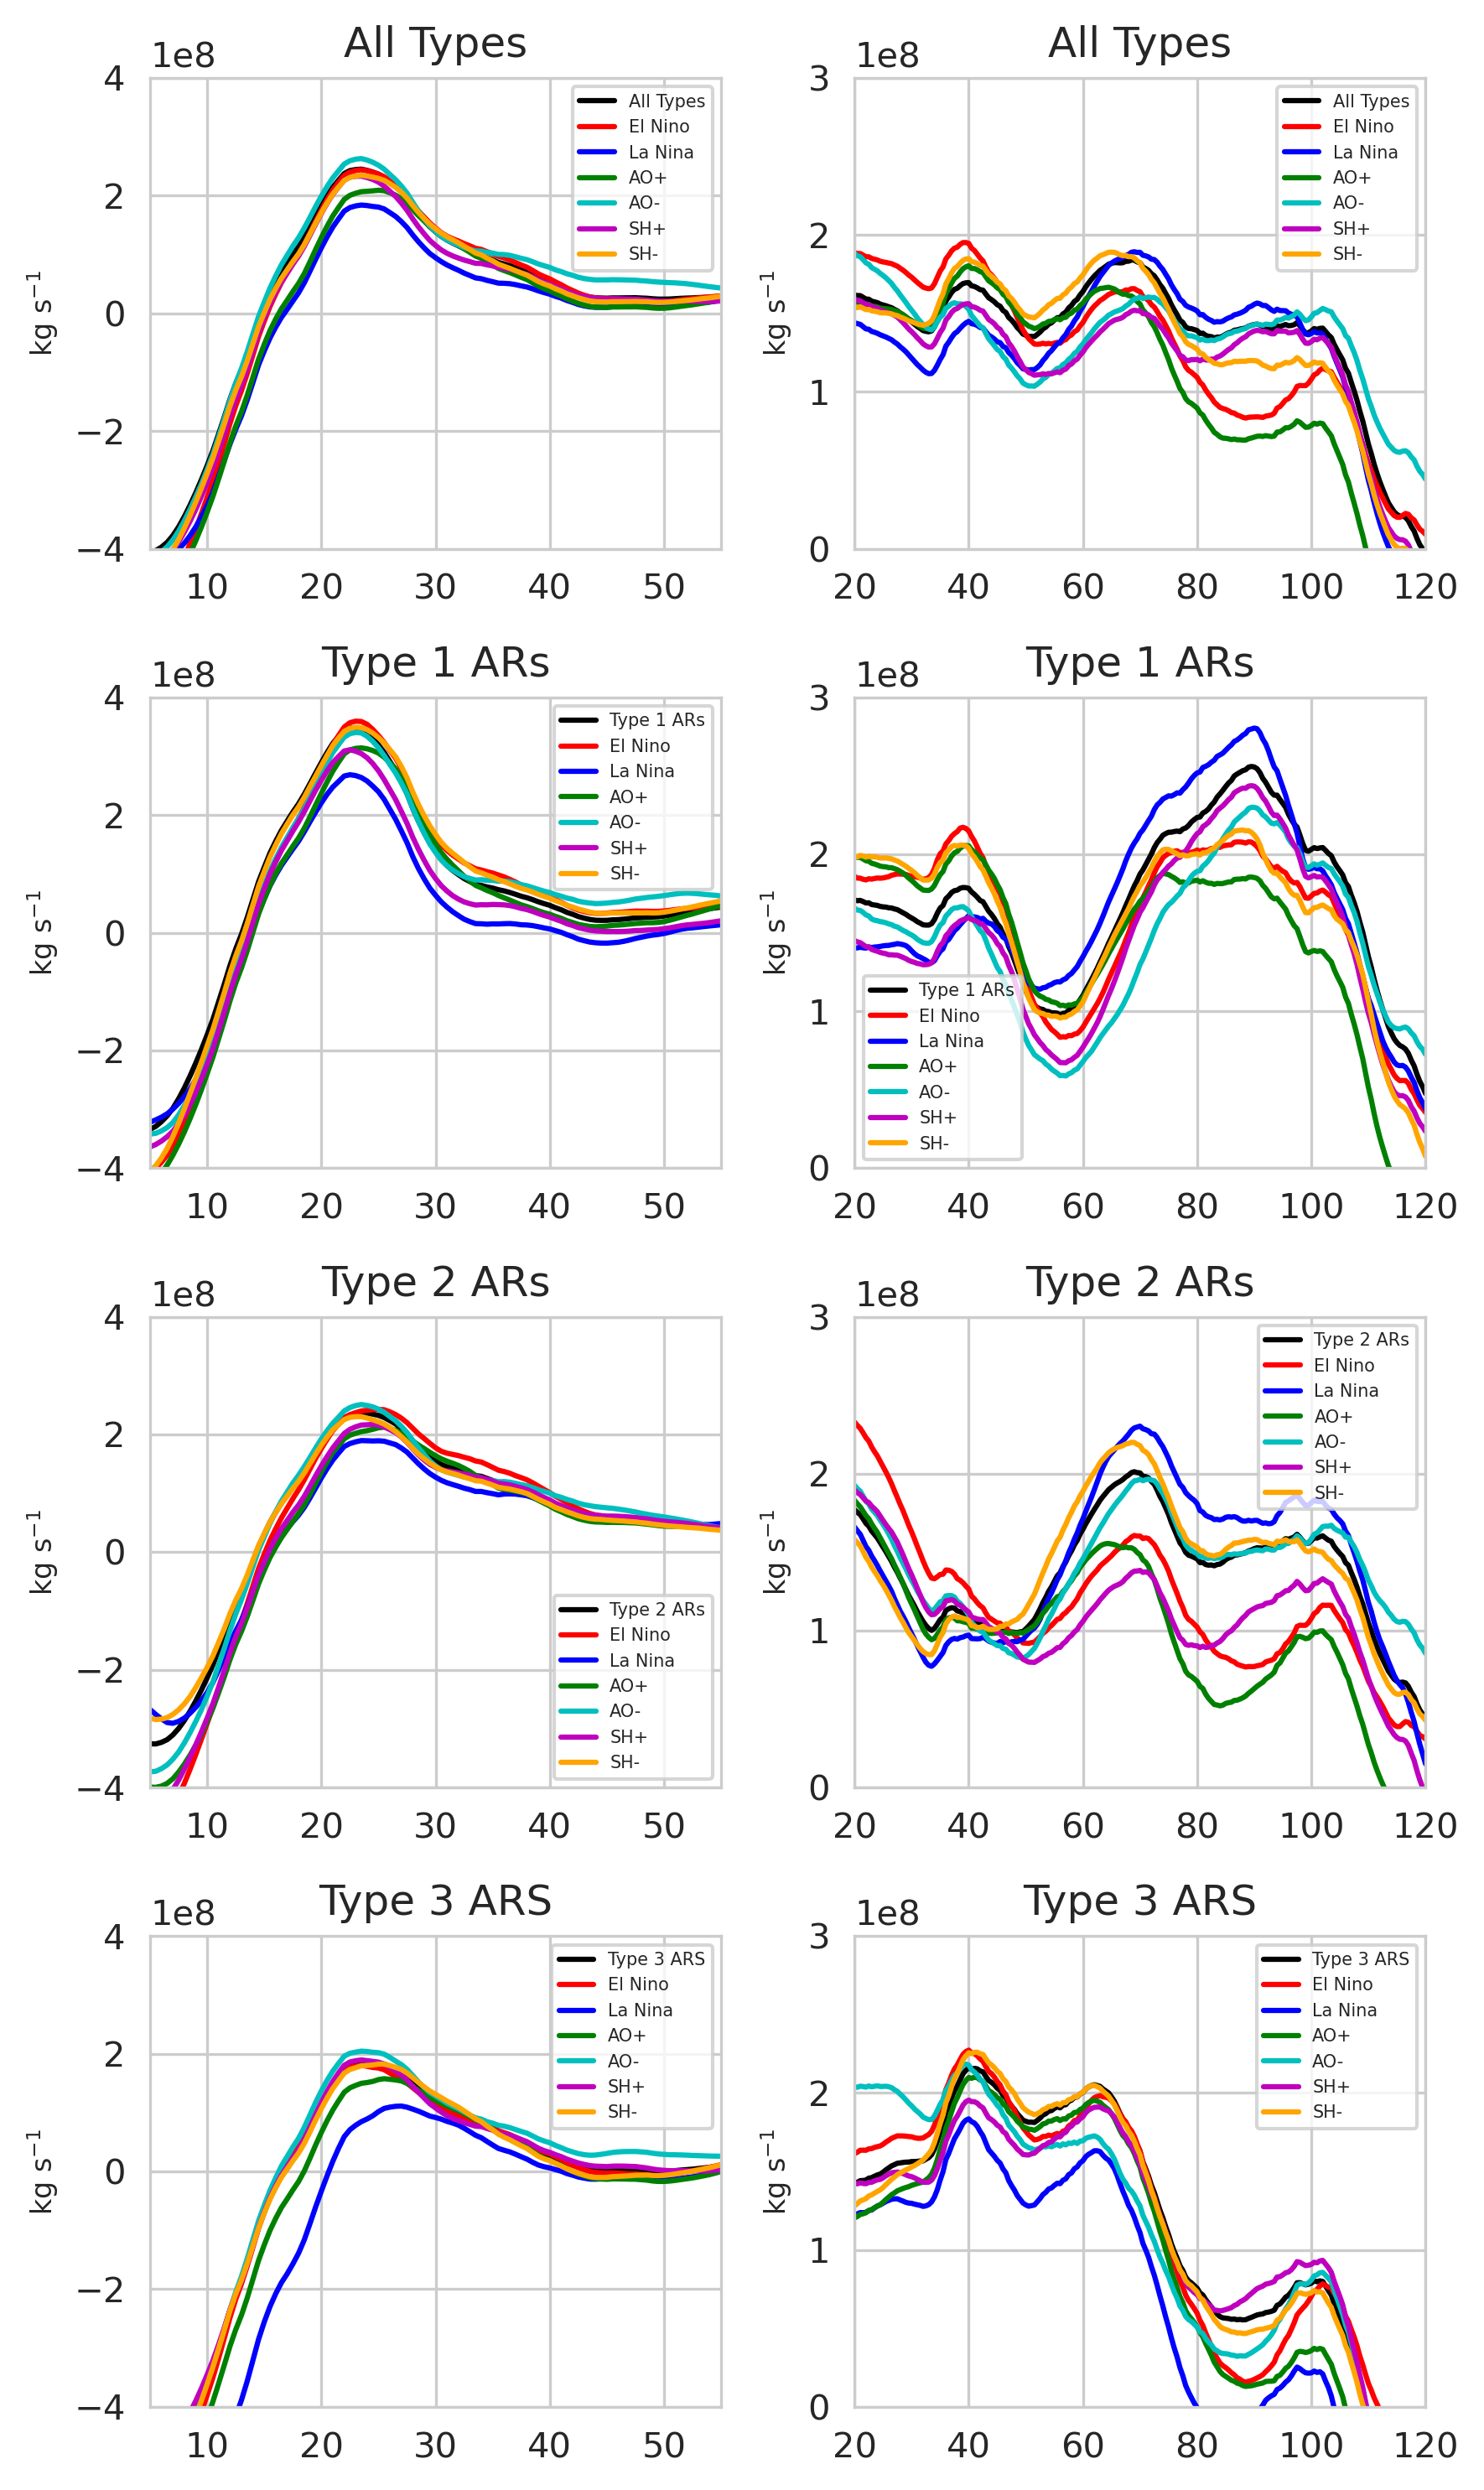

<Figure size 1800x3000 with 0 Axes>

In [53]:
fname = path_to_figs + 'zonal_meridional_plot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((6.0, 10.0))
fig.dpi = 300
nrows = 4
ncols = 2
nplots=nrows*ncols

sns.set_style("whitegrid")

idx_lst = [(ds['AR_CAT'] > 0)]*2 + [(ds['AR_CAT'] == 1)]*2 + [(ds['AR_CAT'] == 2)]*2 + [(ds['AR_CAT'] == 3)]*2

dat_lst = [meridional_ivt, zonal_ivt]*4
dist_lst = [merid_dist, zonal_dist]*4
lat_lon = ['lat', 'lon']*4
ylims = [(-4e8, 4e8), (-1, 3e8)]*4
xlims = [(latmin, latmax), (lonmin, lonmax)]*4
plt_lbl = ['All Types']*2 + ['Type 1 ARs']*2 + ['Type 2 ARs']*2 + ['Type 3 ARS']*2
cli_lst = ['ENSO']*2 + ['AO']*2 + ['SH']*2
cli_lbl = ['El Nino', 'La Nina', 'AO+', 'AO-', 'SH+', 'SH-']
cond_lst = [1, -1]*3
col_lst = ['r', 'b', 'g', 'c', 'm', 'orange']

for i, (idx, data, dist) in enumerate(zip(idx_lst, dat_lst, dist_lst)):

    ax = fig.add_subplot(nrows, ncols, i+1)
    # data to plot
    x = data[lat_lon[i]]
    y = data.sel(time=idx).mean('time').values*dist # convert to kg/s
    g = ax.plot(x, y, color='k', label=plt_lbl[i])
    
    for k, (cli, cond, col) in enumerate(zip(cli_lst, cond_lst, col_lst)):
        idx_new = idx & (ds[cli] == cond)
        z = data.sel(time=idx_new).mean('time').values*dist # convert to kg/s
        h = ax.plot(x, z, color=col, label=cli_lbl[k])

    # Plot titles, etc.
    ax.set_title(plt_lbl[i], fontsize=12)
    ax.set_ylabel('kg s$^{-1}$', fontsize=8)
    plt.ylim(ylims[i])
    plt.xlim(xlims[i])
    ax.legend(fontsize=5)

# Save the figure
fig.tight_layout()
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))